---
**Numerical continuation**

Week 17 of EMAT30008

https://engmaths.github.io/emat30008/odes/numericalcontinuation/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scicomp.odefunctions import *
from scipy.optimize import root

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


----------
We start by prototyping code for natural parameter continuation

We first conduct a single step of natural parameter continuation in the following cell:

In [8]:
# Define a basic polynomial with a parameter c
def polynomial(x,c):
    return x**3 -x + c

# Write out first step by hand
deltac = 0.1
c0 = -1

# Freeze the polynomial with c=c0, 
# Use root finding with an initial guess to find the corresponding root
xpolynomial = lambda x: polynomial(x, c=c0)
x0guess = 1
x0 = root(xpolynomial, x0guess).x
print("x_0 =", x0)

# Update the parameter c, and use the last solution as our initial guess
c1 = c0 + deltac
xpolynomial = lambda x: polynomial(x, c=c1)
x1 = root(xpolynomial, x0).x
print("x_1 =",x1)

x_0 = [1.32471796]
x_1 = [1.30073658]


We now conduct multiple steps of natural parameter continuation and plot the result

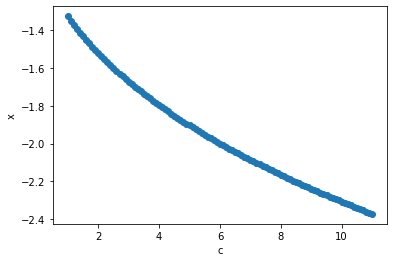

In [11]:
# Define basic polynomial
def polynomial(x,c):
    return x**3 -x + c

# Write out first step by hand
c0 = 1
deltac = 0.1
x0guess = -5
xpolynomial = lambda x: polynomial(x, c=c0)
x0 = root(xpolynomial, x0guess).x

# Define a basic step function
def natural_param_step(xi, ci):
    c_next = ci + deltac
    xpolynomial = lambda x: polynomial(x, c=c_next)
    x_next = root(xpolynomial, xi).x
    return x_next, c_next

# Do some steps
x_store = [x0]
c_store = [c0]

x = x0
c = c0
for i in range(100):
    x, c = natural_param_step(x, c)
    x_store += [x]
    c_store += [c]

# Plot
plt.scatter(c_store, x_store)
plt.xlabel("c")
plt.ylabel("x")
plt.show()

This shows a very basic natural parameter continuation for the polynomial $x^3 -x + c$. 
Note if we change `x0guess` above we get a different plot.

We now do the same but for pseudo-arclength continuation.

------------
Pseudo-arclength continuation


[[ 1.         -1.32471796]
 [ 1.1        -1.34767277]
 [ 1.20020117 -1.36975121]
 [ 1.30057788 -1.39103297]
 [ 1.40110893 -1.41158678]
 [ 1.50177659 -1.43147239]
 [ 1.60256592 -1.45074207]
 [ 1.70346421 -1.46944185]
 [ 1.80446057 -1.48761251]
 [ 1.90554559 -1.50529035]
 [ 2.00671112 -1.52250783]
 [ 2.10795003 -1.53929413]]


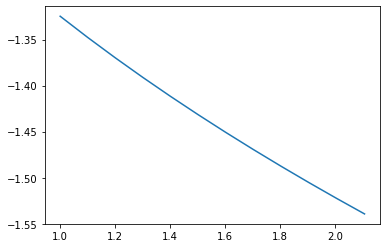

In [20]:
# Redefine polynomial in question, we set x to be an array for future generalisation
def polynomial(c: float, x: np.ndarray):
    return x[0]**3 - x[0] + c

# Start with c0 and an x_0 guess, find x_0
c0, x0guess = 1, np.array(([-5]))
fixed_poly = lambda x: polynomial(c=c0,x=x)
x0 = root(fixed_poly, x0guess).x

# Conduct a single step of natural parameter continuation to obtain x_1
deltac = 0.1
c1 = c0 + deltac
fixed_poly = lambda x: polynomial(c=c1,x=x)
x1guess = x0
x1 = root(fixed_poly, x1guess).x

# Construct v0 and v1 vectors
v0 = np.concatenate(([c0],x0))
v1 = np.concatenate(([c1],x1))

# Initialise stores for looping
v_store = np.stack((v0, v1))
v_last = v0
v_current = v1
num_steps = 10

# Define objective function used for root finding in each step
def psa_objective(v: np.ndarray, v_next_guess: np.ndarray, secant: np.ndarray):
    original = polynomial(c=v[0], x=v[1:])
    pseudo_arclength_eq = np.dot((v - v_next_guess),secant)
    return np.array(([original, pseudo_arclength_eq]))

# Conduct num_steps many steps of pseudo-arclength continuation
for i in range(num_steps):
    # Calculate secant and next guess
    secant = v_current - v_last
    v_next_guess = v_current + secant

    # Define current objective function and find its root for v_next
    current_objective = lambda v: psa_objective(v, v_next_guess, secant)
    v_next = root(current_objective, v_next_guess).x

    # Update
    v_store = np.vstack((v_store, v_next))
    v_last = v_current
    v_current = v_next

# Print and plot our final store
print(v_store)
plt.plot(v_store[:,0], v_store[:,1])
plt.show()

-------
We now write functions for both to generalise the methods, still specific to this ode function. After this we will develop code to take limit cycle or equillibrium points as our objectives.

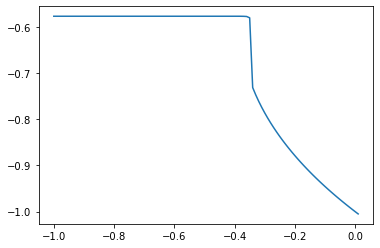

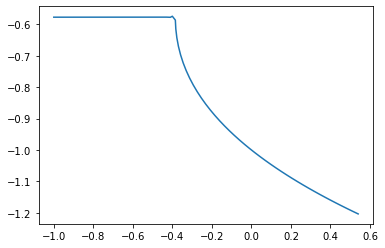

In [10]:
def numerical_continuation_polynomial(polynomial, c0, delta_c, x0guess, num_steps, method):
    
    # Fix parameter in polynomial function
    fixed_poly = lambda x: polynomial(c=c0,x=x)

    # Find x0, here by root finding on objective fixed_poly
    x0 = root(fixed_poly, x0guess).x

    # Update c by delta_c, do the same thing
    c1 = c0 + delta_c
    fixed_poly = lambda x: polynomial(c=c1,x=x)
    x1guess = x0
    x1 = root(fixed_poly, x1guess).x

    if method == 'NPC':
        # Construct stores
        x_store = np.vstack((x0,x1))
        c_store = [c0,c1]
        x_current = x1
        c_current = c1
        
        # Loop over number of steps
        for i in range(num_steps):
            # Update c by delta_c
            c_next = c_current + delta_c

            # Fix the objective function and find the next solution
            fixed_poly = lambda x: polynomial(c=c_next, x=x)
            x_next = root(fixed_poly, x_current).x

            # Update stores and then current values
            x_store = np.vstack((x_store, x_next))
            c_store += [c_next]
            x_current = x_next
            c_current = c_next
    
    elif method == 'PAC':
        # Construct v0 and v1 vectors
        v0 = np.concatenate(([c0],x0))
        v1 = np.concatenate(([c1],x1))

        # Construct stores
        v_store = np.stack((v0, v1))
        v_last = v0
        v_current = v1

        # Define objective function used for root finding in each step
        def psa_objective(v: np.ndarray, v_next_guess: np.ndarray, secant: np.ndarray):
            original = polynomial(c=v[0], x=v[1:])
            pseudo_arclength_eq = np.dot((v - v_next_guess),secant)
            return np.array(([original, pseudo_arclength_eq]))
        
        # Conduct num_steps many steps of pseudo-arclength continuation
        for i in range(num_steps):
            # Calculate secant and next guess
            secant = v_current - v_last
            v_next_guess = v_current + secant

            # Define current objective function and find its root for v_next
            current_objective = lambda v: psa_objective(v, v_next_guess, secant)
            v_next = root(current_objective, v_next_guess).x

            # Update
            v_store = np.vstack((v_store, v_next))
            v_last = v_current
            v_current = v_next
        
        # Unpack v_store into x and c
        c_store, x_store = v_store[:,0], v_store[:,1]

    return x_store, c_store
        
        
def polynomial(c,x):
    return x[0]**3 - x[0] + c

x_store, c_store = numerical_continuation_polynomial(polynomial=polynomial,
                                                      c0=-1, delta_c=0.01,
                                                      x0guess=np.array(([-5])),
                                                      num_steps=100,
                                                      method='NPC')

plt.plot(c_store, x_store)
plt.show()

x_store, c_store = numerical_continuation_polynomial(polynomial=polynomial,
                                                      c0=-1, delta_c=0.01,
                                                      x0guess=np.array(([-5])),
                                                      num_steps=100,
                                                      method='PAC')

plt.plot(c_store, x_store)
plt.show()


TODO: 
-solve $x^3 - x + c = 0$ on paper so we know what to look for

-look at paper notes in folder for review

-implement pseudo-arclength continuation, perhaps find nice way to plot search lines

-make and test framework that can take this and use it for the limit cycle shooting problem, or for equillibria finding. Look at dictionary vs array of parameters, choosing which param to vary etc.

-make functionality to do continuation backwards, and functionality to run continuation multiple times and add new points

-should reproduce some of the tools that XPPauto uses.